In [1]:
%run csiro-biomass-data-loading.ipynb

255 50 51
{'Pre_GSHH_NDVI': {'q50': 0.21079139411449432, 'q75': 0.7403659224510193, 'q90': 1.2037436962127686, 'q95': 1.3361376523971558, 'q99': 1.4632354521751414}, 'Height_Ave_cm': {'q50': -0.2719688415527344, 'q75': 0.3856850862503052, 'q90': 1.4404025077819824, 'q95': 2.3810505628585807, 'q99': 2.7710587978363037}, 'Dry_Clover_g': {'q50': -0.2647244334220886, 'q75': 0.7284159064292908, 'q90': 1.5074969053268432, 'q95': 1.8269424676895119, 'q99': 2.515016226768495}, 'Dry_Dead_g': {'q50': 0.05714616924524307, 'q75': 0.7739342451095581, 'q90': 1.264405083656311, 'q95': 1.4368308544158934, 'q99': 1.7236804413795472}, 'Dry_Green_g': {'q50': 0.21901564300060272, 'q75': 0.6587365567684174, 'q90': 1.1036961793899536, 'q95': 1.3031319260597227, 'q99': 1.667626738548279}, 'Dry_Total_g': {'q50': 0.10779093205928802, 'q75': 0.6682067811489105, 'q90': 1.2109348773956299, 'q95': 1.5225960612297054, 'q99': 1.9445340704917924}, 'GDM_g': {'q50': 0.1054128035902977, 'q75': 0.6984666883945465, 'q90':

In [2]:
# state = train_ds.get_state()
# species2id = state["species2id"]
# print(species2id)

In [3]:
# from torchvision import models
# from torchinfo import summary

# model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# summary = summary(model, input_size=(1, 3, 256, 512), # (B, C, H, W)
#         col_names=("input_size", "output_size", "num_params"),
#         depth=4)

# print(summary)
# print(model)

In [4]:
## The model

import torch
import torch.nn as nn 
import torchvision.models as models

class ResNetBackbone(nn.Module):
    def __init__(self, pretrained: bool = True):
        super().__init__()
        
        if pretrained:
            w = models.ResNet18_Weights.DEFAULT
        else:
            w = None
        
        # use resnet18 instead of resnet34
        m = models.resnet18(weights=w)

        # ResNet stem + layers
        self.conv1   = m.conv1
        self.bn1     = m.bn1
        self.relu    = m.relu
        self.maxpool = m.maxpool
        self.layer1  = m.layer1
        self.layer2  = m.layer2
        self.layer3  = m.layer3   # "higher" features
        self.layer4  = m.layer4   # final features
        self.avgpool = m.avgpool

        # use the **last** block in each layer so it works for 18/34/etc.
        self.out_dim_layer2 = m.layer2[-1].bn2.num_features
        self.out_dim_layer3 = m.layer3[-1].bn2.num_features
        self.out_dim_final  = m.fc.in_features  # 512 for resnet18

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x      = self.layer1(x)
        feat_l2 = self.layer2(x)
        feat_l3 = self.layer3(feat_l2)
        feat_l4 = self.layer4(feat_l3)

        # global pooling for final features
        f_final = self.avgpool(feat_l4)
        f_final = torch.flatten(f_final, 1)  # (B, 512)

        return feat_l2, feat_l3, f_final
    
class Image2BiomassModel(nn.Module):
    def __init__(self, num_species, pretrained=True):
        super().__init__()
        
        self.backbone = ResNetBackbone(pretrained=pretrained)
        
        out_l2 = self.backbone.out_dim_layer2
        out_l3 = self.backbone.out_dim_layer3
        out_final = self.backbone.out_dim_final
        
      
        def make_head_species(out_dim):
            return nn.Sequential(
            # nn.AdaptiveAvgPool2d(output_size=(1, 1)),   # pool layer3 to (B, 256, 1, 1)
            # nn.Flatten(1),                              # (B, 256)
                nn.Linear(in_features=out_final, out_features=256),
                nn.ReLU(inplace=True),
                nn.Dropout(0.4), #
                nn.Linear(256, 128),
                nn.ReLU(inplace=True),
                nn.Dropout(0.2),
                nn.Linear(128, out_dim)
            )
            
        def make_head_ndvi(out_dim):
            return nn.Sequential(
                nn.Linear(out_final, 256),
                nn.ReLU(inplace=True),
                nn.Dropout(0.3),
                nn.Linear(256, 128),
                nn.ReLU(inplace=True),
                nn.Dropout(0.2),
                nn.Linear(128, out_dim)
            )
        
        def make_head_height(out_dim):
            return nn.Sequential(
                nn.Linear(out_final, 256),
                nn.ReLU(inplace=True),
                nn.Dropout(0.3), # 
                nn.Linear(256, 128),
                nn.ReLU(inplace=True),
                nn.Dropout(0.2), # 
                nn.Linear(128, out_dim)
            )
            
        def make_head_biomass(out_dim):
            return nn.Sequential(
                nn.Linear(out_final, 256),
                nn.ReLU(inplace=True),
                nn.Dropout(0.2), # 
                nn.Linear(256, 128),
                nn.ReLU(inplace=True),
                nn.Dropout(0.1), # ++
                nn.Linear(128, out_dim)
            )
        
        def make_head_clover_p(out_dim):
            # Clover presence (binary) -> output is a logit (no sigmoid here)
            return nn.Sequential(
                nn.Linear(out_final, 256),
                nn.ReLU(inplace=True),
                nn.Dropout(0.3),
                nn.Linear(256, 128),
                nn.ReLU(inplace=True),
                nn.Dropout(0.2),
                nn.Linear(128, out_dim)
            )

        def make_head_clover_mag(out_dim):
            # Clover magnitude (regression) -> predict same space as y (standardized log1p)
            return nn.Sequential(
                nn.Linear(out_final, 256),
                nn.ReLU(inplace=True),
                nn.Dropout(0.2),
                nn.Linear(256, 128),
                nn.ReLU(inplace=True),
                nn.Dropout(0.1),
                nn.Linear(128, out_dim)
            )

        
        # custome heads for Image2BiomassModel
        self.head_species = make_head_species(num_species)      # Classfication
        self.head_ndvi    = make_head_ndvi(1)                   # Regression
        self.head_height  = make_head_height(1)                 # Regression
        self.head_biomass    = make_head_biomass(4)     # Dead, Green, Total, GDM
        self.head_clover_p   = make_head_clover_p(1)    # presence logit
        self.head_clover_mag = make_head_clover_mag(1)  # magnitude
       
        
    def forward(self, x):
        out_l2, out_l3, f_final = self.backbone(x)              # IN: torch.Size([1, 3, 256, 512]) -> OUT:
        
        out = {
            "species"   : self.head_species(f_final),                  # (B,C)
            "ndvi"      : self.head_ndvi(f_final).squeeze(-1),         # (B,)
            "height"    : self.head_height(f_final).squeeze(-1),       # (B,)
            "biomass"   : self.head_biomass(f_final),                  # (B,4)
            "clover_p_logit"    : self.head_clover_p(f_final).squeeze(-1),   # (B,)
            "clover_mag"        : self.head_clover_mag(f_final).squeeze(-1), # (B,)
        }
        
        return out

In [5]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

state = train_ds.get_state()
species2id = state["species2id"]
num_species = len(species2id)
print(num_species)

img2bm_model = Image2BiomassModel(num_species=num_species).to(device)
# optimizer = optim.AdamW(img2bm_model.parameters(), lr=1e-4, weight_decay=1e-7)

backbone_params = []
log_s_params = []
species_params, ndvi_params, height_params, biomass_head_params = [], [], [], []

for name, p in img2bm_model.named_parameters():
    if not p.requires_grad:
        continue
    if name.startswith("backbone."):
        backbone_params.append(p)
    elif name.startswith("head_species."):
        species_params.append(p)
    elif name.startswith("head_ndvi."):
        ndvi_params.append(p)
    elif name.startswith("head_height."):
        height_params.append(p)
    elif name.startswith("head_biomass."):
        biomass_head_params.append(p)
    elif name.startswith("log_s_"):
        log_s_params.append(p)
    else:
        # if anything unexpected appears
        backbone_params.append(p)

optimizer = torch.optim.AdamW(
    [
        {"params": backbone_params,      "lr": 1e-4, "weight_decay": 0.0},
        {"params": species_params,       "lr": 1e-4, "weight_decay": 2e-4},
        {"params": ndvi_params,          "lr": 1e-4, "weight_decay": 0.0},
        {"params": height_params,        "lr": 1e-4, "weight_decay": 0.0},
        {"params": biomass_head_params,  "lr": 1e-4, "weight_decay": 0.0},
        {"params": log_s_params,         "lr": 1e-4, "weight_decay": 0.0},
    ]
)
      
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer,
    factor=0.75,
    patience=3, # 7
    threshold=0.01, # .005
    min_lr=1e-7,
    threshold_mode='abs'
)

16


In [6]:
import torch.nn.functional as F
import torch

BIOMASS_WEIGHTS = torch.tensor([0.1, 0.1, 0.1, 0.5, 0.2])  # Clover, Dead, Green, Total, GDM

def smooth_l1(x, y, beta=1.0, reduction="none"):
    return F.smooth_l1_loss(x, y, beta=beta, reduction=reduction)


#  total_loss, loss_parts = multitask_losses(preds, targets, log_s_params, tail_q,
#                                               epoch=epoch, max_epoch=max_epoch, device=device)
def multitask_losses(preds, targets, tail_q=None, stats=None, beta=1.0,
                     epoch=None, max_epoch=None, device=None):
    
    if stats is None:
        raise ValueError("stats is required for clover presence inversion")

    # Extract the predictions
    species_logits      = preds["species"]       # (B, num_species) logits
    ndvi_hat            = preds["ndvi"]          # (B,)
    height_log_hat      = preds["height"]        # (B,)
    biomass_hat         = preds["biomass"]       # (B,4)
    
    y_true          = targets["y"]
    species_true    = targets["species_id"].long()
    
    ndvi_true        = y_true[:, 0]
    height_log_true  = y_true[:, 1]
    biomass_true     = y_true[:, 3:7]  # (B,4)
    
    # ---- species ----
    loss_species    = F.cross_entropy(species_logits, species_true, label_smoothing=0.05)

    # Pre_GSHH_NDVI  Height_Ave_cm  Dry_Clover_g  Dry_Dead_g  Dry_Green_g  Dry_Total_g GDM_g
    
    # ---- NDVI (bounded) ----
    loss_ndvi    = F.mse_loss(ndvi_hat, ndvi_true)

    # ---- build tail sample weights (example: emphasize high Dry_Total and high GDM) ----
    dry_total = biomass_true[:, 2]  # adjust index to your order!
    gdm       = biomass_true[:, 3]
    # simple, stable: boost top end softly
    
    if tail_q is None:
        w = torch.ones_like(dry_total)
    else:
        q90_dt = torch.tensor(tail_q["Dry_Total_g"]["q90"], device=dry_total.device, dtype=dry_total.dtype)
        q99_dt = torch.tensor(tail_q["Dry_Total_g"]["q99"], device=dry_total.device, dtype=dry_total.dtype)
        q90_g  = torch.tensor(tail_q["GDM_g"]["q90"],       device=gdm.device,       dtype=gdm.dtype)
        q99_g  = torch.tensor(tail_q["GDM_g"]["q99"],       device=gdm.device,       dtype=gdm.dtype)

        t_dt = ((dry_total - q90_dt) / (q99_dt - q90_dt + 1e-8)).clamp(0.0, 1.0)  # 0..1 ramp
        t_g  = ((gdm       - q90_g ) / (q99_g  - q90_g  + 1e-8)).clamp(0.0, 1.0)
        
        w = torch.ones_like(dry_total)
        w = w + (1.5 * t_dt) + (0.5 * t_g)
    
    w = w.detach()
       
    # height_true is already transformed (log1p + normalized) coming from dataloader
    l_h = F.smooth_l1_loss(height_log_hat, height_log_true, beta=beta, reduction="none")
    loss_height = (w * l_h).sum() / (w.sum() + 1e-8)
    
    # ---- Clover: two-part ----
    clover_z = y_true[:, 2]  # (B,)  <-- this is standardized log1p(clover)

    # --- invert transform to get raw clover (>=0) for presence label ---
    # stats must be fitted on the SAME transformed space:
    #   mu,sigma of log1p(clamp(raw,0))
    mu_c, sig_c = stats["Dry_Clover_g"]     # floats
    mu_c  = torch.tensor(mu_c,  device=clover_z.device, dtype=clover_z.dtype)
    sig_c = torch.tensor(sig_c, device=clover_z.device, dtype=clover_z.dtype)
    
    clover_log1p = clover_z * sig_c + mu_c      # (B,) log1p(clover_clipped)
    clover_raw   = torch.expm1(clover_log1p).clamp_min(0.0)  # (B,) approximate raw (>=0)
    clover_pos   = (clover_raw > 0.0).float()   # (B,)
    
    # --- part 1: presence classifier ---
    loss_clover_p = F.binary_cross_entropy_with_logits(preds["clover_p_logit"], clover_pos)
    
    # magnitude only on positives, in SAME space as target (z-space)
    pos_mask = clover_pos.bool()
    if pos_mask.any():
        w_pos = w[pos_mask]
        l_cm = F.smooth_l1_loss(preds["clover_mag"][pos_mask], clover_z[pos_mask], beta=beta, reduction="none")  # (n_pos,)
        loss_clover_mag = (w_pos * l_cm).sum() / (w_pos.sum() + 1e-8)
    else:
        loss_clover_mag = preds["clover_mag"].sum() * 0.0
    
    # ---- Other biomass dims: log1p + SmoothL1, weighted per target ----
    # Here assume preds["biomass"] excludes clover dim if you move clover to 2-part.
    # Example: remaining dims are [Dry_Dead, Dry_Green, Dry_Total, GDM] (4 dims)
    other_true = biomass_true
    
    l_b = smooth_l1(preds["biomass"], other_true, beta=beta, reduction="none")  # (B,4)
    l_b = (w[:, None] * l_b).sum(dim=0) / (w.sum() + 1e-8)  # (4,)

    bw = BIOMASS_WEIGHTS.to(l_b.device, l_b.dtype)  # make sure these match leaderboard!
    bw_other = bw[1:]  # if bw[0] was clover weight

    # --- combine ---
    # combine
    loss_biomass = (bw[0] * (loss_clover_p + loss_clover_mag) + (bw_other * l_b).sum()) / (bw[0] + bw_other.sum() + 1e-8)

    # fallback (if you ever disable uncertainty weighting)
    total_loss = loss_species + loss_ndvi + loss_height + loss_biomass
    
    loss_parts = {"species": loss_species.detach(), "ndvi": loss_ndvi.detach(),
                    "height": loss_height.detach(), "biomass": loss_biomass.detach()}
    
    return total_loss, loss_parts

import torch
import torch.nn.functional as F

@torch.inference_mode()
def multitask_accuracies(preds, targets, stats=None):
    species_logits = preds["species"]
    ndvi_hat       = preds["ndvi"]
    height_hat     = preds["height"]
    biomass_hat    = preds["biomass"]          # (B,4)
    clover_p_logit = preds["clover_p_logit"]   # (B,)
    clover_mag_hat = preds["clover_mag"]       # (B,)

    y_true       = targets["y"]
    species_true = targets["species_id"].long()

    ndvi_true   = y_true[:, 0]
    height_true = y_true[:, 1]
    clover_z    = y_true[:, 2]        # standardized log1p(clover)
    other_true  = y_true[:, 3:7]      # (B,4) [Dead,Green,Total,GDM]

    # --- species accuracy ---
    species_acc = (species_logits.argmax(dim=1) == species_true).float().mean()

    # --- helper to convert mse -> score (monitoring only) ---
    def err_to_score(x):
        return 1.0 / (1.0 + x)

    # --- ndvi / height mse (monitoring) ---
    ndvi_mse   = F.mse_loss(ndvi_hat, ndvi_true)
    height_mse = F.mse_loss(height_hat, height_true)

    # --- biomass mse (weighted across 4 dims) ---
    # IMPORTANT: BIOMASS_WEIGHTS should now be for 4 dims, or slice it appropriately.
    # If your old BIOMASS_WEIGHTS is length 5 with clover first, do bw_other = BIOMASS_WEIGHTS[1:]
    bw = BIOMASS_WEIGHTS.to(biomass_hat.device, dtype=biomass_hat.dtype)
    if bw.numel() == 5:
        bw = bw[1:]  # drop clover weight for biomass_hat (B,4)

    mse_per_dim = ((biomass_hat - other_true) ** 2).mean(dim=0)  # (4,)
    biomass_mse = (bw * mse_per_dim).sum() / (bw.sum() + 1e-8)

    # --- clover presence accuracy + clover magnitude mse ---
    clover_p_acc = torch.tensor(0.0, device=species_acc.device)
    clover_mag_mse = torch.tensor(0.0, device=species_acc.device)

    if stats is not None:
        mu_c, sig_c = stats["Dry_Clover_g"]
        mu_c  = torch.tensor(mu_c,  device=clover_z.device, dtype=clover_z.dtype)
        sig_c = torch.tensor(sig_c, device=clover_z.device, dtype=clover_z.dtype)

        clover_log1p = clover_z * sig_c + mu_c
        clover_raw   = torch.expm1(clover_log1p).clamp_min(0.0)
        clover_pos   = (clover_raw > 0.0).float()  # (B,)

        clover_pred = (torch.sigmoid(clover_p_logit) > 0.5).float()
        clover_p_acc = (clover_pred == clover_pos).float().mean()

        # magnitude mse only on positives
        pos_mask = clover_pos.bool()
        if pos_mask.any():
            clover_mag_mse = F.mse_loss(clover_mag_hat[pos_mask], clover_z[pos_mask])
        else:
            clover_mag_mse = torch.tensor(0.0, device=clover_z.device)

    return {
        "species":    species_acc,
        "ndvi":       err_to_score(ndvi_mse),
        "height":     err_to_score(height_mse),
        "biomass":    err_to_score(biomass_mse),
        "clover_p":   clover_p_acc,
        "clover_mag": err_to_score(clover_mag_mse),
    }


In [7]:
import torch

BIOMASS_COLS = ["Dry_Clover_g", "Dry_Dead_g", "Dry_Green_g", "Dry_Total_g", "GDM_g"]
BIOMASS_W    = torch.tensor([0.1, 0.1, 0.1, 0.5, 0.2], dtype=torch.float64)  # matches cols above

def _inv_transform(col: str, x: torch.Tensor, state: dict) -> torch.Tensor:
    """
    x: tensor on standardized (and maybe log1p) scale -> returns raw scale tensor
    """
    stats = state["stats"]
    cfg   = state.get("target_cfg", {})

    mu, sig = stats[col]
    x = x * sig + mu

    if cfg.get(col, {}).get("log1p", False):
        x = torch.expm1(x)
        x = torch.clamp(x, min=0.0)

    return x

@torch.inference_mode()
def compute_biomass_r2_components_raw(model, data_loader, device, state, eps=1e-12):
    """
    Computes globally-weighted R^2 on RAW biomass scale using leaderboard weights.
    Works with:
      preds["biomass"]        -> (B,4) for [Dry_Dead, Dry_Green, Dry_Total, GDM]
      preds["clover_p_logit"] -> (B,)
      preds["clover_mag"]     -> (B,)  (z-space: standardized log1p(clover))
    Targets in batch["y"] are transformed space (log1p+standardized where configured).
    """

    model.eval()

    all_pred_raw = []
    all_true_raw = []

    for batch in data_loader:
        images = batch["img_t"].to(device)
        y_true = batch["y"].to(device)   # (B,7) transformed

        preds = model(images)

        # ----- TRUE transformed values for the 5 biomass cols -----
        # y layout: [NDVI, Height, Clover, Dead, Green, Total, GDM]
        y_true_bio5 = y_true[:, 2:7]  # (B,5) -> [Clover, Dead, Green, Total, GDM]

        # ----- PRED transformed values -----
        # biomass head is (B,4): [Dead, Green, Total, GDM] in z-space
        bio4_hat = preds["biomass"]  # (B,4)

        # clover two-part heads
        clover_p = torch.sigmoid(preds["clover_p_logit"])  # (B,) in [0,1]
        clover_z_hat = preds["clover_mag"]                 # (B,) z-space

        # ----- convert predictions to RAW scale -----
        # clover magnitude to raw via inverse transform; then "gate" by p (soft)
        clover_raw_mag = _inv_transform("Dry_Clover_g", clover_z_hat, state)  # (B,)
        clover_raw_hat = (clover_p * clover_raw_mag).clamp_min(0.0)          # (B,)

        dead_raw_hat  = _inv_transform("Dry_Dead_g",  bio4_hat[:, 0], state)
        green_raw_hat = _inv_transform("Dry_Green_g", bio4_hat[:, 1], state)
        total_raw_hat = _inv_transform("Dry_Total_g", bio4_hat[:, 2], state)
        gdm_raw_hat   = _inv_transform("GDM_g",       bio4_hat[:, 3], state)

        y_pred_raw = torch.stack(
            [clover_raw_hat, dead_raw_hat, green_raw_hat, total_raw_hat, gdm_raw_hat],
            dim=1
        )  # (B,5)

        # ----- convert truths to RAW scale -----
        clover_raw_true = _inv_transform("Dry_Clover_g", y_true_bio5[:, 0], state)
        dead_raw_true   = _inv_transform("Dry_Dead_g",   y_true_bio5[:, 1], state)
        green_raw_true  = _inv_transform("Dry_Green_g",  y_true_bio5[:, 2], state)
        total_raw_true  = _inv_transform("Dry_Total_g",  y_true_bio5[:, 3], state)
        gdm_raw_true    = _inv_transform("GDM_g",        y_true_bio5[:, 4], state)

        y_true_raw = torch.stack(
            [clover_raw_true, dead_raw_true, green_raw_true, total_raw_true, gdm_raw_true],
            dim=1
        )  # (B,5)

        all_pred_raw.append(y_pred_raw.detach().cpu())
        all_true_raw.append(y_true_raw.detach().cpu())

    y_pred = torch.cat(all_pred_raw, dim=0).to(torch.float64)  # (N,5) raw
    y_true = torch.cat(all_true_raw, dim=0).to(torch.float64)  # (N,5) raw

    # ----- weighted global R^2 across all (image,target) pairs -----
    # BIOMASS_W must correspond to columns: [Clover, Dead, Green, Total, GDM]
    w = BIOMASS_W.to(y_true.device, dtype=y_true.dtype)        # (5,)
    w_mat = w.unsqueeze(0).expand_as(y_true)                   # (N,5)

    yt = y_true.reshape(-1)    # (N*5,)
    yp = y_pred.reshape(-1)    # (N*5,)
    wf = w_mat.reshape(-1)     # (N*5,)

    y_bar_w = (wf * yt).sum() / (wf.sum() + eps)
    ss_res = (wf * (yt - yp) ** 2).sum()
    ss_tot = (wf * (yt - y_bar_w) ** 2).sum()
    r2_w = 1.0 - ss_res / (ss_tot + eps)

    return {
        "ss_res": ss_res.item(),
        "ss_tot": ss_tot.item(),
        "r2_w":  r2_w.item(),
    }



In [8]:
def train_one_epoch(model, optimizer, train_dl, tail_q=None, stats=None, epoch=None, max_epoch=None, device=torch.device("cuda")):
    model.train()

    total = 0
    running_loss = {"species": 0.0, "ndvi": 0.0, "height": 0.0, "biomass": 0.0}
    running_acc  = {"species": 0.0, "ndvi": 0.0, "height": 0.0, "biomass": 0.0}

    for batch in train_dl:
        optimizer.zero_grad(set_to_none=True)

        images = batch["img_t"].to(device)            # (B,3,H,W)
        y_true = batch["y"].to(device)                # (B,7)
        species_id = batch["species_id"].to(device)   # (B,)

        targets = {"y": y_true, "species_id": species_id}

        preds = model(images)

        total_loss, loss_parts = multitask_losses(preds, targets, tail_q=tail_q, stats=stats, epoch=epoch,
                                                  max_epoch=max_epoch, device=device)

        total_loss.backward()
        optimizer.step()

        bs = images.size(0)
        total += bs

        with torch.inference_mode():
            batch_acc = multitask_accuracies(preds, targets)
            for k in running_loss:
                running_loss[k] += loss_parts[k].item() * bs
                running_acc[k]  += batch_acc[k].item() * bs

    return {k: v/total for k, v in running_loss.items()}, {k: v/total for k, v in running_acc.items()}


def eval_one_epoch(model, eval_dl, stats=None, epoch=None, max_epoch=None, device=torch.device("cuda")):
    model.eval()

    total = 0
    running_loss = {"species": 0.0, "ndvi": 0.0, "height": 0.0, "biomass": 0.0}
    running_acc  = {"species": 0.0, "ndvi": 0.0, "height": 0.0, "biomass": 0.0}

    with torch.inference_mode():
        for batch in eval_dl:
            images = batch["img_t"].to(device)
            y_true = batch["y"].to(device)
            species_id = batch["species_id"].to(device)

            targets = {"y": y_true, "species_id": species_id}

            preds = model(images)

            total_loss, loss_parts = multitask_losses(preds, targets, stats=stats, epoch=epoch, max_epoch=max_epoch, device=device)

            bs = images.size(0)
            total += bs

            batch_acc = multitask_accuracies(preds, targets)
            for k in running_loss:
                running_loss[k] += loss_parts[k].item() * bs
                running_acc[k]  += batch_acc[k].item() * bs

    return {k: v/total for k, v in running_loss.items()}, {k: v/total for k, v in running_acc.items()}


# [Epoch 01/25]:Train loss: species:2.4264, ndvi:0.5508, height:0.6323, biomass:1.2123
def fmt_metrics(d, factor=1.0, precision=4):
    return ", ".join(f"{k[:2]}:{factor * float(v):3.{precision}f}" for k, v in d.items())


def fit(model, optimizer=optimizer, sched=None, train_dl=None, valid_dl=None,
        epochs=25, verbose_every=5, device=torch.device("cuda"), state=None):

    history = {"train_loss": [], "train_acc": [], "valid_loss": [], "valid_acc": [],
               "val_comp": [], "lr": []}
    
    state = train_dl.dataset.get_state()
    stats = state["stats"]
    tail_q = state["tail_q"]
    species2id = state["species2id"]
    
    max_epoch = epochs + 1
    for ep in range(1, max_epoch):
        train_losses, train_accs = train_one_epoch(model, optimizer=optimizer, train_dl=train_dl,
                                                   tail_q=tail_q, stats=stats, epoch=ep, max_epoch=max_epoch, device=device)
        
        valid_losses, valid_accs = eval_one_epoch(model, eval_dl=valid_dl, stats=stats, epoch=ep, max_epoch=max_epoch, device=device)

        if sched is not None:
            bio_val_loss = valid_losses["biomass"]
            if hasattr(sched, "step") and "plateau" in sched.__class__.__name__.lower():
                sched.step(bio_val_loss)
            else:
                sched.step()

        curr_lr = optimizer.param_groups[0]["lr"]

        # --- R2 on RAW biomass scale ---
        if state is None:
            raise ValueError("fit(..., state=...) is required to compute RAW-scale R2.")
        val_comp = compute_biomass_r2_components_raw(model, valid_dl, device, state)

        history["val_comp"].append(val_comp)

        history["train_loss"].append(train_losses)
        history["train_acc"].append(train_accs)
        history["valid_loss"].append(valid_losses)
        history["valid_acc"].append(valid_accs)
        history["lr"].append(curr_lr)

        print(f"[Epoch {ep:02d}/{epochs:02d}]:\n"
              f"Train loss: {fmt_metrics(train_losses)} |"
              f"Train metrics: {fmt_metrics(train_accs, factor=100, precision=2)}\n"
              f"Valid loss: {fmt_metrics(valid_losses)} |"
              f"Valid metrics: {fmt_metrics(valid_accs, factor=100, precision=2)} |"
              f"lr: {curr_lr:.8f}\n"
              f"VAL  RSS={val_comp['ss_res']:.4f}  TSS={val_comp['ss_tot']:.4f}  R2w={val_comp['r2_w']:.4f}")

    return history

In [9]:
EPOCHS = 25

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

history = fit(model=img2bm_model, optimizer=optimizer, sched=scheduler, train_dl=train_dl, 
              valid_dl=val_dl, epochs=EPOCHS, verbose_every=1, device=device, state=state)


/home/onkar/.venvs/cv-dl-env/lib/python3.12/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Epoch 01/25]:
Train loss: sp:2.7434, nd:0.8900, he:0.4239, bi:0.5133 |Train metrics: sp:10.59, nd:55.07, he:52.72, bi:51.56
Valid loss: sp:2.7209, nd:0.6568, he:0.4503, bi:0.4877 |Valid metrics: sp:28.00, nd:61.23, he:45.71, bi:50.36 |lr: 0.00010000
VAL  RSS=41102.7021  TSS=51744.6495  R2w=0.2057
[Epoch 02/25]:
Train loss: sp:2.5766, nd:0.5699, he:0.3370, bi:0.4448 |Train metrics: sp:33.73, nd:65.15, he:58.61, bi:54.89
Valid loss: sp:2.6090, nd:0.4047, he:0.4207, bi:0.4432 |Valid metrics: sp:30.00, nd:72.32, he:47.20, bi:52.57 |lr: 0.00010000
VAL  RSS=34926.1422  TSS=51744.6495  R2w=0.3250
[Epoch 03/25]:
Train loss: sp:2.4240, nd:0.3486, he:0.2653, bi:0.3966 |Train metrics: sp:43.14, nd:74.95, he:65.11, bi:57.82
Valid loss: sp:2.4739, nd:0.1989, he:0.3559, bi:0.4041 |Valid metrics: sp:32.00, nd:83.65, he:53.12, bi:55.37 |lr: 0.00010000
VAL  RSS=27548.3795  TSS=51744.6495  R2w=0.4676
[Epoch 04/25]:
Train loss: sp:2.2752, nd:0.1997, he:0.1948, bi:0.3489 |Train metrics: sp:40.78, nd:83.5

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt


def plot_part_metrics(history=history):
    epochs = range(1, len(history["train_loss"]) + 1)
    metrics = ["species", "ndvi", "height", "biomass"]
    
    fig, axes = plt.subplots(2, 4, figsize=(30, 10), constrained_layout=True)
    
    # -- Training/Validation losses -- 
    for i, m in enumerate(metrics):
        ax = axes[0, i]
        train_vals = [d[m] for d in history["train_loss"]]
        valid_vals = [d[m] for d in history["valid_loss"]]
        
        ax.plot(epochs, train_vals, label="Training loss")
        ax.plot(epochs, valid_vals, label="Validation loss")
        ax.set_title(f"{m} loss")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.grid(True)
        ax.legend()
    
    # -- Training/Validation accuracy --
    for i, m in enumerate(metrics):
        ax = axes[1, i]
        train_vals = [d[m]*100 for d in history["train_acc"]]
        valid_vals = [d[m]*100 for d in history["valid_acc"]]
        
        ax.plot(epochs, train_vals, label="Training acc")
        ax.plot(epochs, valid_vals, label="Validation acc")
        ax.set_title(f"{m} loss")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.grid(True)
        ax.legend()
        
    plt.show()
    

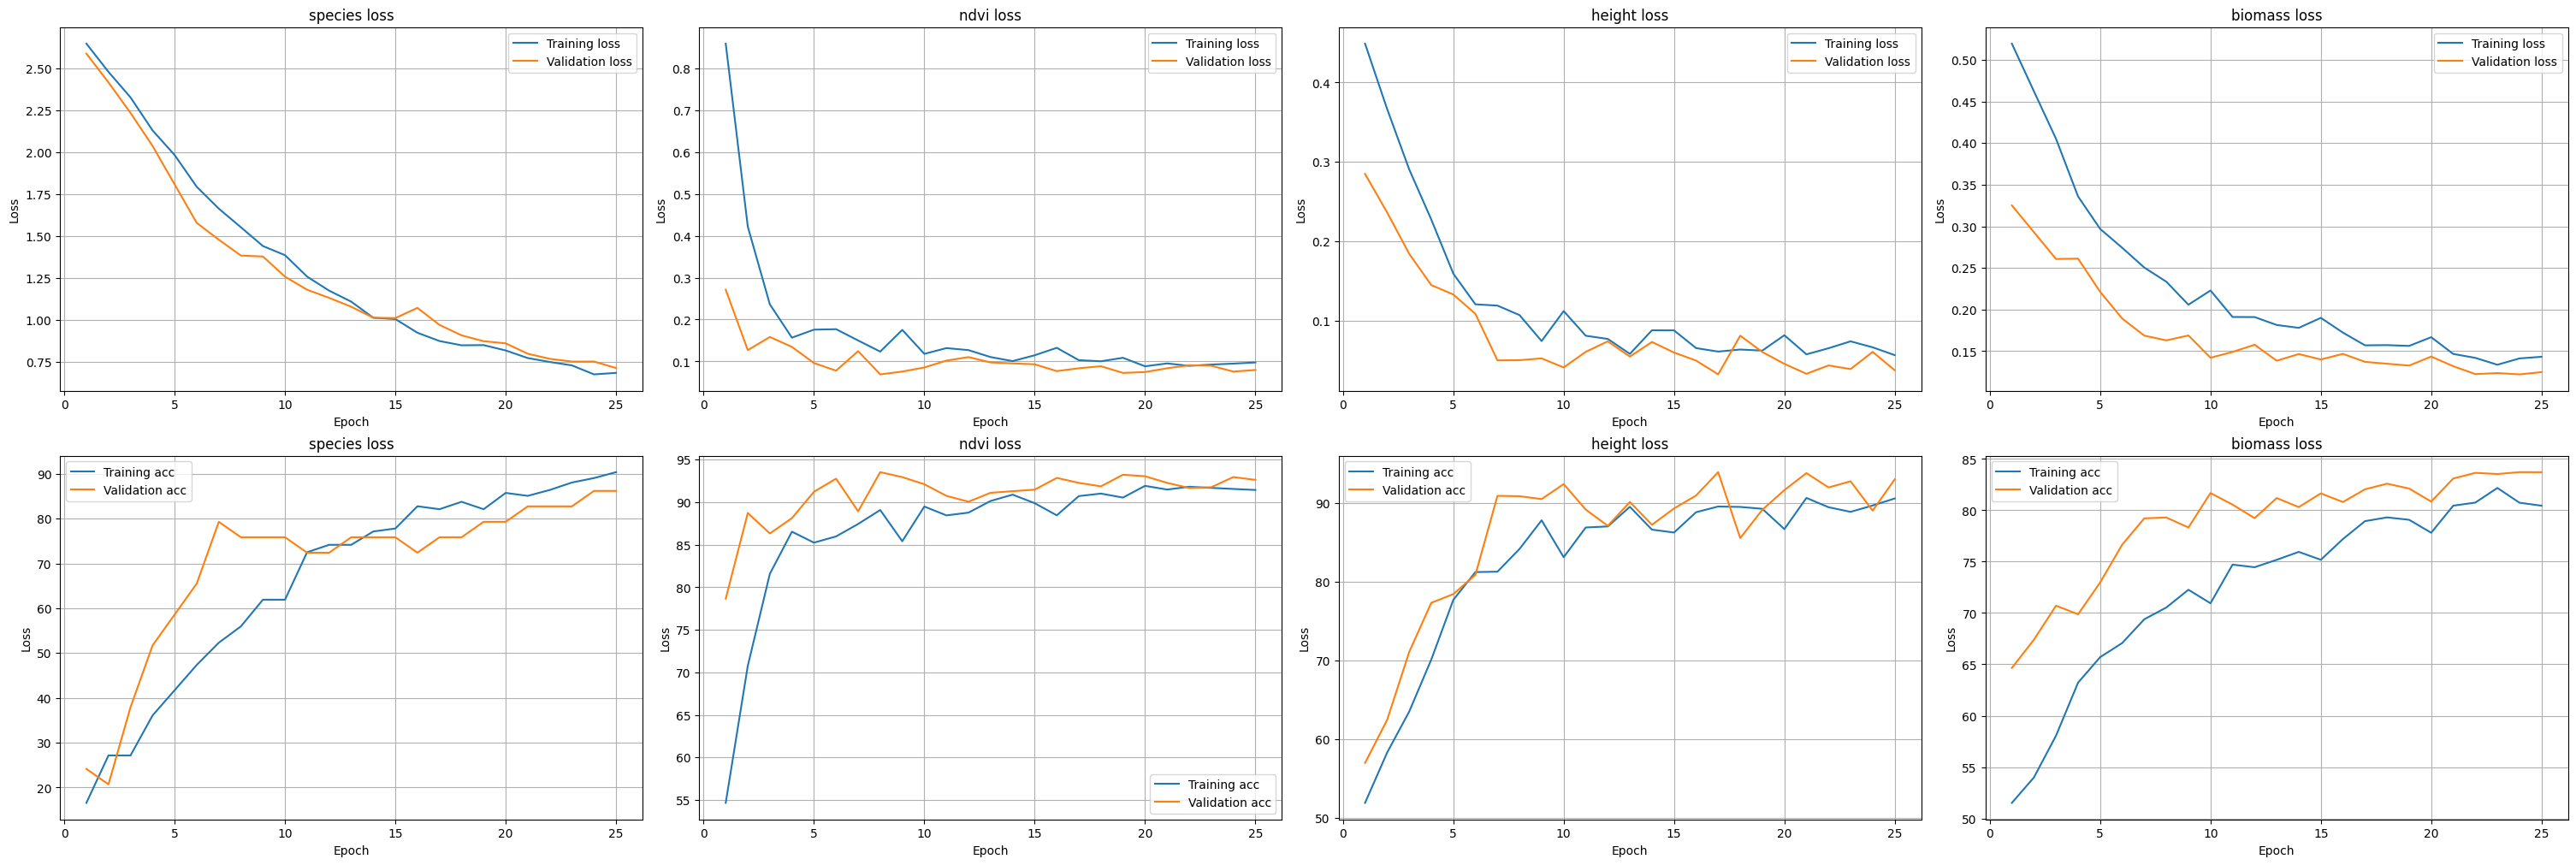

In [ ]:
plot_part_metrics(history)

In [ ]:
test_losses, test_accs = eval_one_epoch(img2bm_model, test_dl, device=torch.device("cuda"))

test_comp = compute_biomass_r2_components_raw(img2bm_model, test_dl, device, state)

print(f"test_losses: {test_losses}, test_accs: {test_accs}")
print(f"VAL  RSS={test_comp['ss_res']:.4f}  TSS={test_comp['ss_tot']:.4f}  R2w={test_comp['r2_w']:.4f}")


In [ ]:
from datetime import date
import torch

fname = f"/kaggle/working/csiro_multitask_ckpt_{date.today().isoformat()}.pt"

ckpt = {
    "model_state": img2bm_model.state_dict(),
    "state": state,
}

torch.save(ckpt, fname)
print("Saved:", fname)


Saved: /kaggle/working/csiro_multitask_ckpt_2025-12-18.pt
